In [340]:
import numpy as np
import pandas as pd

from __future__ import print_function
#from sklearn.cross_validation import train_test_split
import pandas as pd
import numpy as np
np.random.seed(1337)  # for reproducibility
from keras.preprocessing import sequence
# from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding
from keras.layers import  LSTM, SimpleRNN, GRU
from keras.datasets import imdb
# from keras.utils.np_utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.preprocessing import Normalizer
import h5py
from keras import callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel


df = pd.read_csv('kdd+.csv')
df.head()

,Duration,Protocol_Type,Service,Flag,Src_Bytes,Dst_Bytes,Land,Wrong_Fragment,Urgent,Hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,Attack
0,0,tcp,private,REJ,0,0,0,0,0,0,...,10,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,anomaly
1,0,tcp,private,REJ,0,0,0,0,0,0,...,1,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,anomaly
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,86,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,57,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,anomaly
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,86,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,anomaly


## Converting Categorical String into Numeric Data.
*   Protocol_Type
> tcp: 1, udp: 2, icmp: 3
*   Service
> private: 1, ftp_data: 2, eco_i: 3, telnet: 4, etc...
*   Flag
> REJ: 1, SF: 2, 	RSTO: 3, etc...



In [341]:
# Protocol Type Conversion
df["Protocol_Type"]=df["Protocol_Type"].replace({"tcp":1})
df["Protocol_Type"]=df["Protocol_Type"].replace({"udp":2})
df["Protocol_Type"]=df["Protocol_Type"].replace({"icmp":3})

C:\Users\Avani\AppData\Local\Temp\ipykernel_131884\1806463853.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Protocol_Type"]=df["Protocol_Type"].replace({"icmp":3})


In [342]:
# Creating new columns for numeric codes of Service and Flag
df['Serv_code'] = pd.factorize(df['Service'])[0] + 1
df['Flag_code'] = pd.factorize(df['Flag'])[0] + 1

In [343]:
df.head()

,Duration,Protocol_Type,Service,Flag,Src_Bytes,Dst_Bytes,Land,Wrong_Fragment,Urgent,Hot,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,Attack,Serv_code,Flag_code
0,0,1,private,REJ,0,0,0,0,0,0,...,0.06,0.00,0.00,0.0,0.0,1.00,1.00,anomaly,1,1
1,0,1,private,REJ,0,0,0,0,0,0,...,0.06,0.00,0.00,0.0,0.0,1.00,1.00,anomaly,1,1
2,2,1,ftp_data,SF,12983,0,0,0,0,0,...,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal,2,2
3,0,3,eco_i,SF,20,0,0,0,0,0,...,0.00,1.00,0.28,0.0,0.0,0.00,0.00,anomaly,3,2
4,1,1,telnet,RSTO,0,15,0,0,0,0,...,0.17,0.03,0.02,0.0,0.0,0.83,0.71,anomaly,4,3


## Converting Attack Types into Binary Classification 0 and 1.
*   Anomaly : 1
*   Normal: 0
cols = ['Attack', 'Duration', 'Protocol_Type', 'Src_Bytes','Dst_Bytes', 'Land', 'Wrong_Fragment', 'Urgent', 'Hot', 'Num_Failed_Logins', 'Logged_in', 'Num_Compromised', 'Root_shell',	'Su_attempted', 'Num_Root', 'Num_File_Creations', 'Num_shells', 'Num_access_files', 'Num_Outbound_cmds',	'is_host_login',	'is_guest_login',	'count',	'srv_count',	'serror_rate',	'srv_serror_rate',	'rerror_rate',	'srv_rerror_rate',	'same_srv_rate',	'diff_srv_rate', 'srv_diff_host_rate',	'dst_host_count',	'dst_host_srv_count',	'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',	'dst_host_same_src_port_rate',	'dst_host_srv_diff_host_rate',	'dst_host_serror_rate',	'dst_host_srv_serror_rate',	'dst_host_rerror_rate',	'dst_host_srv_rerror_rate',	'Serv_code',	'Flag_code']

In [344]:
df["Attack"]=df["Attack"].replace({"anomaly":1})
df["Attack"]= df["Attack"].replace({"normal":0})

C:\Users\Avani\AppData\Local\Temp\ipykernel_131884\1922081905.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Attack"]= df["Attack"].replace({"normal":0})


In [345]:
df.head()

,Duration,Protocol_Type,Service,Flag,Src_Bytes,Dst_Bytes,Land,Wrong_Fragment,Urgent,Hot,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,Attack,Serv_code,Flag_code
0,0,1,private,REJ,0,0,0,0,0,0,...,0.06,0.00,0.00,0.0,0.0,1.00,1.00,1,1,1
1,0,1,private,REJ,0,0,0,0,0,0,...,0.06,0.00,0.00,0.0,0.0,1.00,1.00,1,1,1
2,2,1,ftp_data,SF,12983,0,0,0,0,0,...,0.04,0.61,0.02,0.0,0.0,0.00,0.00,0,2,2
3,0,3,eco_i,SF,20,0,0,0,0,0,...,0.00,1.00,0.28,0.0,0.0,0.00,0.00,1,3,2
4,1,1,telnet,RSTO,0,15,0,0,0,0,...,0.17,0.03,0.02,0.0,0.0,0.83,0.71,1,4,3


## Normalizing the Features of our Training Dataset

In [346]:
x = df.drop(["Attack", "Service", "Flag"], axis=1)
y= df["Attack"]
normalized_arr = preprocessing.normalize(x)
print(normalized_arr)

[[0.00000000e+00 2.91515444e-03 0.00000000e+00 ... 2.91515444e-03
  2.91515444e-03 2.91515444e-03]
 [0.00000000e+00 3.46002104e-03 0.00000000e+00 ... 3.46002104e-03
  3.46002104e-03 3.46002104e-03]
 [1.54036010e-04 7.70180048e-05 9.99924756e-01 ... 0.00000000e+00
  1.54036010e-04 1.54036010e-04]
 ...
 [0.00000000e+00 1.81253895e-05 9.88558745e-01 ... 1.26877727e-06
  9.06269477e-05 3.62507791e-05]
 [0.00000000e+00 5.49826046e-03 1.15463470e-01 ... 0.00000000e+00
  3.84878232e-02 5.49826046e-03]
 [0.00000000e+00 3.88469598e-03 0.00000000e+00 ... 3.88469598e-03
  1.01002095e-01 3.88469598e-03]]


In [347]:
norm_df=pd.DataFrame(normalized_arr)
norm_df.columns = x.columns
norm_df["Attack"]=y
norm_df.head()

,Duration,Protocol_Type,Src_Bytes,Dst_Bytes,Land,Wrong_Fragment,Urgent,Hot,Num_Failed_Logins,Logged_in,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,Serv_code,Flag_code,Attack
0,0.000000,0.002915,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000175,0.000000,0.000000,0.0,0.0,0.002915,0.002915,0.002915,0.002915,1
1,0.000000,0.003460,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000208,0.000000,0.000000,0.0,0.0,0.003460,0.003460,0.003460,0.003460,1
2,0.000154,0.000077,0.999925,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000003,0.000047,0.000002,0.0,0.0,0.000000,0.000000,0.000154,0.000154,0
3,0.000000,0.033731,0.224874,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.011244,0.003148,0.0,0.0,0.000000,0.000000,0.033731,0.022487,1
4,0.010810,0.010810,0.000000,0.162144,0.0,0.0,0.0,0.0,0.0,0.0,...,0.001838,0.000324,0.000216,0.0,0.0,0.008972,0.007675,0.043238,0.032429,1


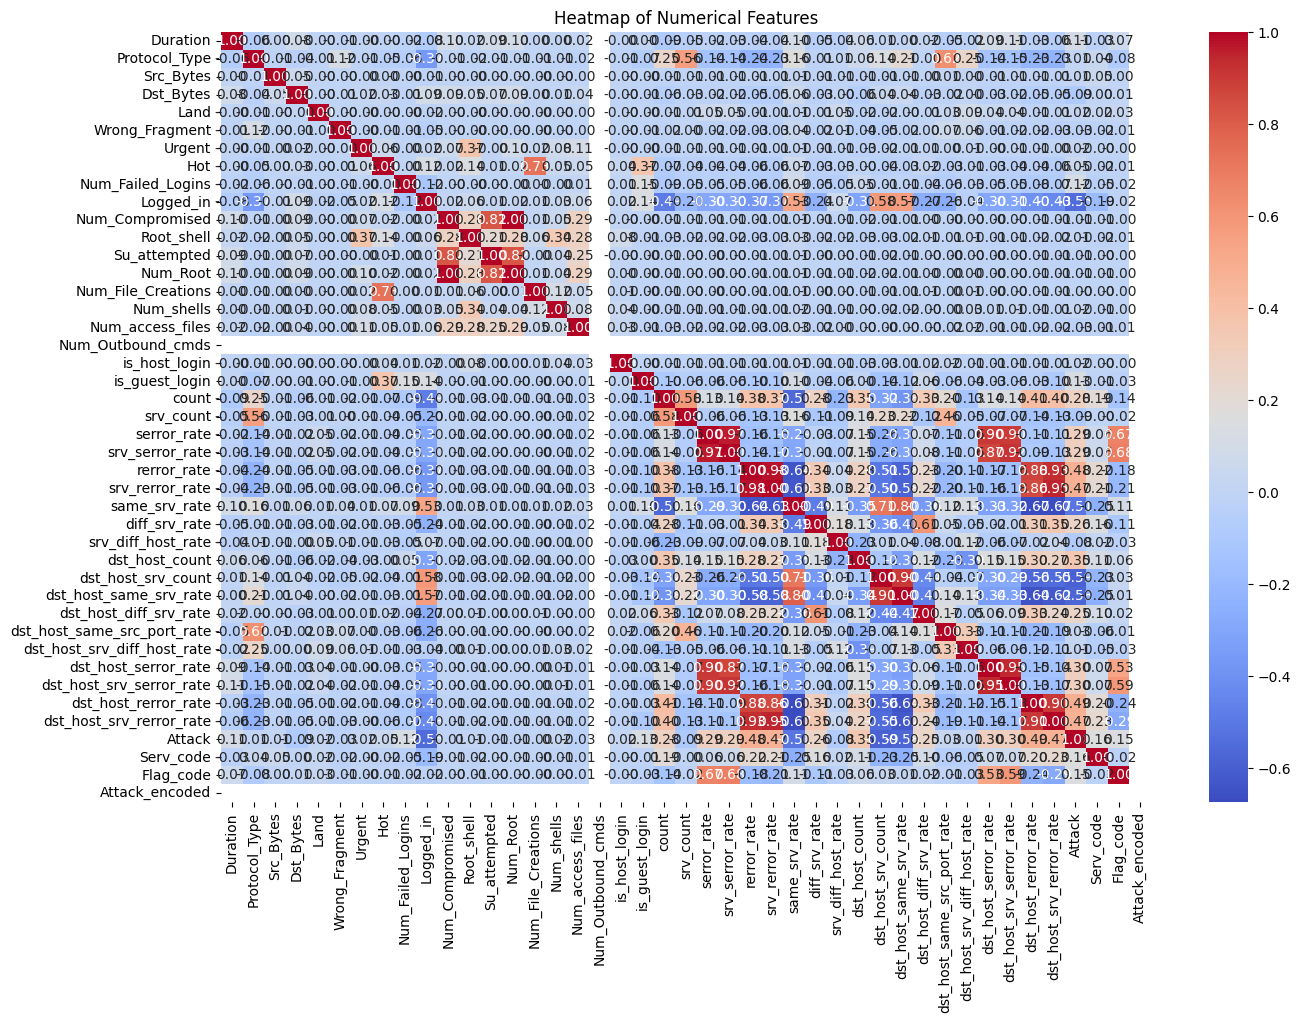

In [348]:
import matplotlib.pyplot as plt
import seaborn as sns
df['Attack_encoded'] = df['Attack'].map({'normal': 0, 'anomaly': 1})
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = df[numerical_columns].corr()
# Plot the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(
    correlation_matrix,
    annot=True,    # Add numerical correlation values
    fmt=".2f",     # Format of the numbers
    cmap='coolwarm', # Color palette
    cbar=True      # Include color bar
)
plt.title('Heatmap of Numerical Features')
plt.show()

In [349]:
#norm_df.corr()

## Splitting the Dataset into Training and Testing Dataset 
Here, we have considered the ratio of 60:40 to split the dataset into train and test dataset respectively.

In [350]:
X_train, X_test, y_train, y_test = train_test_split(x,y,train_size=0.6,test_size=0.4, random_state=42)


We can clearly observe that the dataset is splitted into train and test data with a ratio of 60:40

## Feature Selection

In [351]:
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X_train, y_train)


SelectFromModel(estimator=RandomForestClassifier())

In [352]:
sel.get_support()

array([ True,  True,  True,  True, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False,  True,  True,  True,  True, False, False,
       False,  True,  True,  True, False])

In [353]:
selected_feat= X_train.columns[(sel.get_support())]
len(selected_feat)

13

In [354]:
print(selected_feat)

Index(['Duration', 'Protocol_Type', 'Src_Bytes', 'Dst_Bytes', 'Logged_in',
       'count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'Serv_code'],
      dtype='object')


In [355]:
X_train = X_train[['Duration', 'Protocol_Type', 'Src_Bytes', 'Dst_Bytes', 'Logged_in',
       'count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'Serv_code']]
X_test = X_test[['Duration', 'Protocol_Type', 'Src_Bytes', 'Dst_Bytes', 'Logged_in',
       'count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'Serv_code']]



In [356]:
X_test = X_test.to_numpy()
X_train = X_train.to_numpy()

In [357]:
X_train.shape

(13526, 13)

In [358]:
# reshape input to be [samples, time steps, features]
X_train  = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
batch_size = 32

Training the model...
Epoch 1/10


C:\Users\Avani\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


423/423 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4879 - loss: 0.7310 - val_accuracy: 0.5084 - val_loss: 0.6568
Epoch 2/10
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5176 - loss: 0.6239 - val_accuracy: 0.5431 - val_loss: 0.5848
Epoch 3/10
423/423 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5432 - loss: 0.5813 - val_accuracy: 0.8328 - val_loss: 0.5638
Epoch 4/10
423/423 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7944 - loss: 0.5524 - val_accuracy: 0.8442 - val_loss: 0.4511
Epoch 5/10
423/423 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8116 - loss: 0.4569 - val_accuracy: 0.8534 - val_loss: 0.4052
Epoch 6/10
423/423 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8322 - loss: 0.4058 - val_accuracy: 0.8747 - val_loss: 0.3662
Epoch 7/10
423/423 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8413 - loss: 0.3819 - val_accuracy: 0.8749 - val_loss: 0.3430
Epoch 8/10
423/423 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8481 - loss: 0.3552 - val_accuracy: 0.8765 - val_

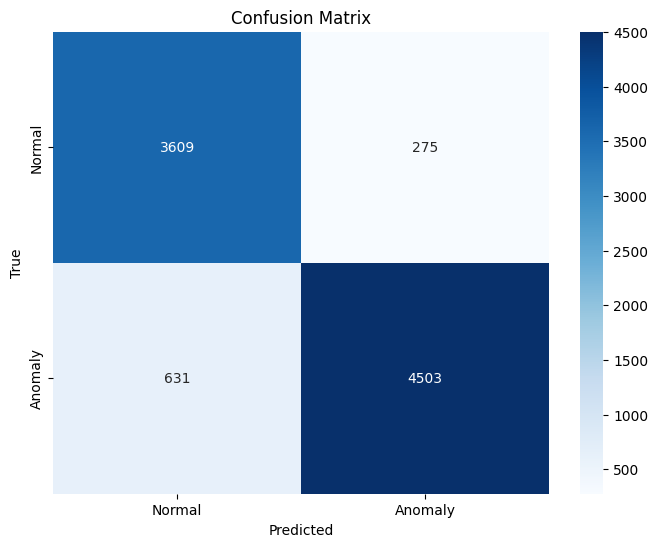

In [359]:
model = Sequential()
model.add(LSTM(4,input_shape=(1,13)))  # try using a GRU instead, for fun
model.add(Dropout(0.1))
model.add(Dense(1))
model.add(Activation('sigmoid'))
#print(model.get_config())

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print("Training the model...")
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Make predictions on the test set
print("Making predictions...")
y_pred_prob = model.predict(X_test)  # Predict probabilities
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions

# Generate and print evaluation metrics
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Anomaly']))

# confusion matrix
print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

# Plot confusion matrix (optional)
# import seaborn as sns
# import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [360]:
model.summary()

Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_36 (LSTM)                  │ (None, 4)              │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1)              │             5 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_34 (Activation)      │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 881 (3.45 KB)

 Trainable params: 293 (1.14 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 588 (2.30 KB)

In [361]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
checkpointer = callbacks.ModelCheckpoint(filepath="checkpoint-{epoch:02d}.hdf5.keras", verbose=1, save_best_only=True, monitor='val_acc',mode='max')
csv_logger = CSVLogger('training_set_iranalysis.csv',separator=',', append=False)
model.fit(X_train, y_train, batch_size=batch_size, epochs=50, validation_data=(X_test, y_test),callbacks=[checkpointer,csv_logger])
model.save("lstm1layer_model.hdf5.keras")

Epoch 1/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8568 - loss: 0.3234 - val_accuracy: 0.8807 - val_loss: 0.2851
Epoch 2/50
 56/423 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8595 - loss: 0.3084

C:\Users\Avani\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\model_checkpoint.py:206: UserWarning: Can save best model only with val_acc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8580 - loss: 0.3130 - val_accuracy: 0.8797 - val_loss: 0.2763
Epoch 3/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8578 - loss: 0.3113 - val_accuracy: 0.8790 - val_loss: 0.2727
Epoch 4/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8570 - loss: 0.3053 - val_accuracy: 0.9177 - val_loss: 0.2697
Epoch 5/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8537 - loss: 0.3056 - val_accuracy: 0.8826 - val_loss: 0.2649
Epoch 6/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8546 - loss: 0.3089 - val_accuracy: 0.9197 - val_loss: 0.2621
Epoch 7/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8623 - loss: 0.2891 - val_accuracy: 0.9215 - val_loss: 0.2565
Epoch 8/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8623 - loss: 0.2942 - val_accuracy: 0.9179 - val_loss: 0.2624
Epoch 9/50
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8577 - loss: 0.2970 - val_accuracy: 0.9236 - val_

In [362]:
loss, accuracy = model.evaluate(X_test, y_test)
print("\nLoss: %.2f, Accuracy: %.2f%%" % (loss, accuracy*100))
y_pred = model.predict(X_test)
classes_x=np.argmax(y_pred,axis=1)
# print(classes_x)

282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9314 - loss: 0.2313

Loss: 0.23, Accuracy: 92.98%
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
